# Brain Tumor MRI Image Classification 
> By Salar Mokhtari Laleh - 2024

## What is brain tumor? 
A brain tumor is a collection, or mass, of abnormal cells in your brain. Your skull, which encloses your brain, is very rigid. Any growth inside such a restricted space can cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening.

In [1]:
import os
import shutil
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import time
import imutils

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle

%matplotlib inline
plt.style.use('ggplot')

# Import Datasets
Link of Dataset: (https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?resource=download)


In [2]:
# Unzip Dataset 

import zipfile

dataset_zip = zipfile.ZipFile('Brain_Tumor_Datasets.zip')
dataset_zip.extractall()

In [3]:
# Rename Yes files to uniqe format name

folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count)+ ".jpg"
    os.rename(source, destination)
    count+=1
    
print("The Task is done")

The Task is done


In [4]:
# Rename Yes files to uniqe format name

folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count)+ ".jpg"
    os.rename(source, destination)
    count+=1
    
print("The Task is done")

The Task is done


## Exploratory Data Analysi

In [5]:
# Yes
yes_list = os.listdir('brain_tumor_dataset/yes/')
number_yes_files = len(yes_list)
print("Number of Yes files of datasets: " + str(number_yes_files))

# No
no_list = os.listdir('brain_tumor_dataset/no/')
number_no_files = len(no_list)
print("Number of No files of datasets: " + str(number_no_files))

Number of Yes files of datasets: 155
Number of No files of datasets: 98


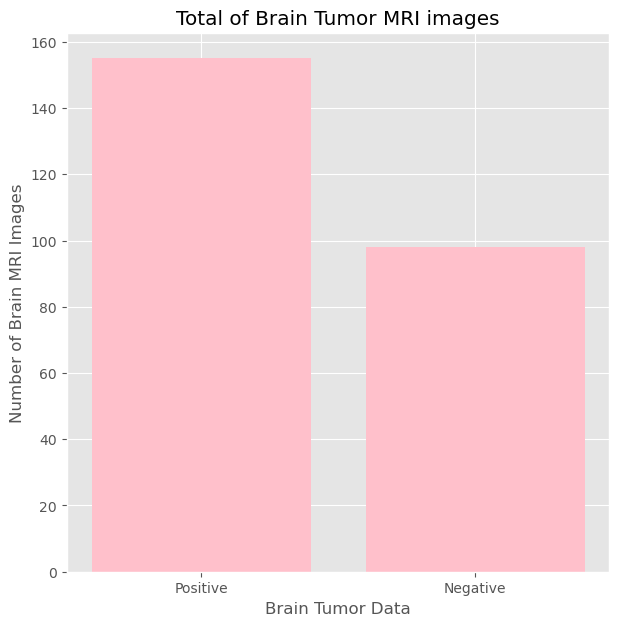

In [6]:
# Making plot 

data = {'Positive': number_yes_files, 'Negative': number_no_files}
X_type = data.keys()
values = data.values()

# Craeting Figure
fig = plt.figure(figsize=(7,7))
plt.xlabel('Brain Tumor Data')
plt.ylabel('Number of Brain MRI Images')
plt.title('Total of Brain Tumor MRI images')
plt.bar(X_type, values, color="pink")
plt.show()

## Data Augmentation 

In [7]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [8]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1,
                                   save_to_dir = save_to_dir,
                                   save_prefix = save_prefix,
                                   save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [9]:
start_time = time.time()

positive_path = 'brain_tumor_dataset/yes' 
negative_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = positive_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augmented_data(file_dir = negative_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:19.51731824874878


In [10]:
def data_summary(main_path):
    positive_path = 'augmented_data/yes' 
    negative_path = 'augmented_data/no'

    number_positive = len(os.listdir(positive_path))
    number_negative = len(os.listdir(negative_path))
    total_number_data = number_positive + number_negative
    positive_percent = (number_positive*100)/total_number_data
    negative_percent = (number_negative*100)/total_number_data

    print(f"Total number of dataset: {total_number_data}")
    print(f"{number_positive} is number of positive sample & in percentage : {positive_percent}%")
    print(f"{number_negative} is number of negative sample & in percentage : {negative_percent}%")

In [11]:
data_summary(augmented_data_path)

Total number of dataset: 2065
1085 is number of positive sample & in percentage : 52.54237288135593%
980 is number of negative sample & in percentage : 47.45762711864407%


In [12]:
# Positive
positive_list = os.listdir('augmented_data/yes/')
number_positive_files = len(positive_list)
print("Number of Positive files of datasets: " + str(number_positive_files))

# Negative
negative_list = os.listdir('augmented_data/no/')
number_negative_files = len(negative_list)
print("Number of Negative files of datasets: " + str(number_negative_files))

Number of Positive files of datasets: 1085
Number of Negative files of datasets: 980


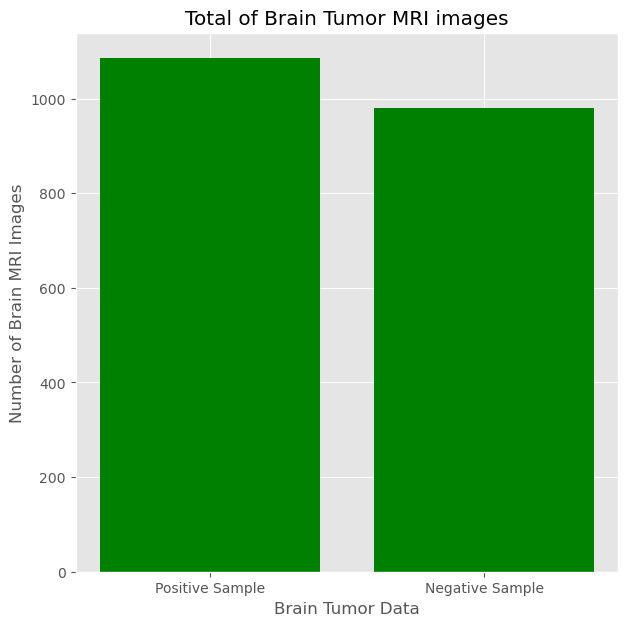

In [13]:
# Making plot 

data = {'Positive Sample': number_positive_files, 'Negative Sample': number_negative_files}
X_type = data.keys()
values = data.values()

# Craeting Figure
fig = plt.figure(figsize=(7,7))
plt.xlabel('Brain Tumor Data')
plt.ylabel('Number of Brain MRI Images')
plt.title('Total of Brain Tumor MRI images')
plt.bar(X_type, values, 
        color="green")
plt.show()

## Data Preprocessing
 Convert BGR to GRAY

In [22]:
def crop_brain_tumor_MRI(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

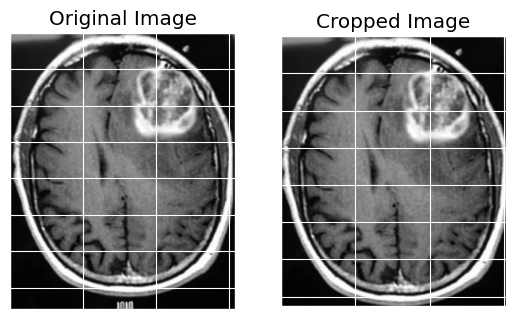

array([[[177, 177, 177],
        [135, 135, 135],
        [112, 112, 112],
        ...,
        [ 61,  61,  61],
        [ 76,  76,  76],
        [ 88,  88,  88]],

       [[140, 140, 140],
        [128, 128, 128],
        [121, 121, 121],
        ...,
        [ 58,  58,  58],
        [ 73,  73,  73],
        [ 86,  86,  86]],

       [[122, 122, 122],
        [129, 129, 129],
        [133, 133, 133],
        ...,
        [ 52,  52,  52],
        [ 68,  68,  68],
        [ 80,  80,  80]],

       ...,

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2]],

       [[  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [  2,   2,   2],
        [  2,   2,   2],
        [  2,   2,   2]]

In [23]:
img = cv2.imread('augmented_data/yes/aug_Y_28_0_9548.jpg')
crop_brain_tumor_MRI(img, True)

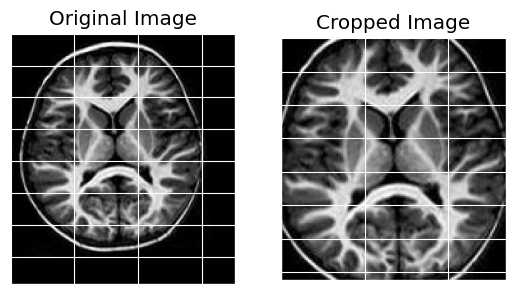

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [2, 2, 2]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]]], dtype=uint8)

In [24]:
img = cv2.imread('augmented_data/no/aug_N_6_0_9936.jpg')
crop_brain_tumor_MRI(img, True)

In [25]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor_MRI(image, plot = False)
            image = cv2.resize(image, dsize=(image_width, image_height),
                              interpolation = cv2.INTER_CUBIC)
            image = image / 255.00
            X.append(image)
            if directory[-3:0] == 'yes':
                y.append(1)
            else:
                y.append(0)

    X = np.array(X)
    y = np.array(y)
    X,y = shuffle(X,y)

    print(f'Number of example is : {len(X)}')
    print(f'X SHAPE is : {X.shape}')
    print(f'y SHAPE is : {y.shape}')
    return X,y

In [26]:
augmented_path = 'augmented_data/'
augmented_positive = augmented_path + 'yes'
augmented_negative = augmented_path + 'no'

IMAGE_WIDIH, IMAGE_HEIGHT = (240, 240)

X,y = load_data([augmented_positive, augmented_negative], (IMAGE_WIDIH, IMAGE_HEIGHT))

Number of example is : 2065
X SHAPE is : (2065, 240, 240, 3)
y SHAPE is : (2065,)
